# Sentiment Analysis using Vader, TextBlob and Flair

In this notebook, we will be performing sentiment analysis on the Spotify reviews dataset, which contains thousands of reviews from customers.

The dataset can be downloaded on Kaggle: 
https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022?select=reviews.csv 

Lets begin by loading all the necessary libraries

In [1]:
pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Pr

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import string
import nltk
import re
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from time import time

### Exploratory Data Analysis

In [5]:
# import dataset
data= pd.read_csv('/content/reviews.csv')

print(f'Number of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}')

Number of rows: 61594
Number of columns: 5


In [6]:
data.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [7]:
data.describe()

,Rating,Total_thumbsup
count,61594.000000,61594.000000
mean,3.155989,7.649381
std,1.673285,89.323143
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8195.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [9]:
# Convert Time_submitted from oject to datetime format)
data['Time_submitted'] = pd.to_datetime(data['Time_submitted'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time_submitted  61594 non-null  datetime64[ns]
 1   Review          61594 non-null  object        
 2   Rating          61594 non-null  int64         
 3   Total_thumbsup  61594 non-null  int64         
 4   Reply           216 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.3+ MB


In [11]:
# missing data
data.isna().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

In [12]:
# duplicated reviews 
data.duplicated().sum()

0

There is a major peak of negative reviews in early March of 2022 and another peak of negative reviews mid April. This could be an indication of a bug issue. However, from May onwards positve ratings make up majority of the reviews. 

In [13]:
# Number of Reviews Over Time for each Rating
dailyNumOfReviewsEachRatings = data.groupby('Rating').resample('d', on='Time_submitted').size().sort_index().T

fig = go.Figure()
for k in range(len(dailyNumOfReviewsEachRatings.columns)):
    fig.add_trace(go.Scatter(y=dailyNumOfReviewsEachRatings[dailyNumOfReviewsEachRatings.columns[k]],
                             x=dailyNumOfReviewsEachRatings.index,
                             mode='lines',
                             name=f"Rating of {dailyNumOfReviewsEachRatings.columns[k]}",
                             line=dict(width=1.5)))

fig.update_layout(
    yaxis=dict(title_text="Number of Reviews", titlefont=dict(size=15)),
    xaxis=dict(title_text="Date", titlefont=dict(size=15)),
    title={'text': f"Number of Reviews Over Time for each Rating",
           'x': 0.5})
fig.update_traces(marker=dict(line=dict(color='#000000', width=1.2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

Reviews range from 0 to 3500 charaters but majority range between 0 and 500.

In [14]:
data['length'] = data['Review'].str.len()

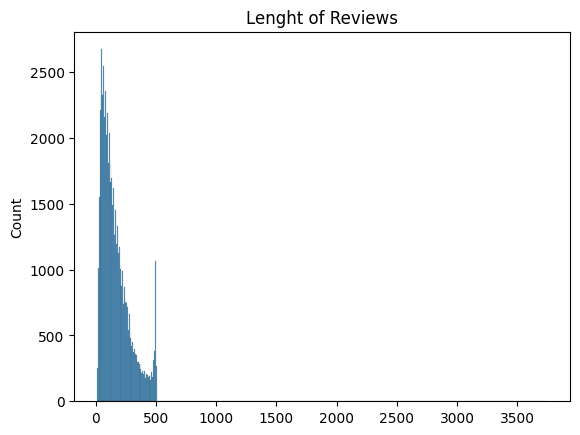

In [15]:
sns.histplot(data['length'])
plt.title('Lenght of Reviews')
plt.xlabel('')
plt.show()

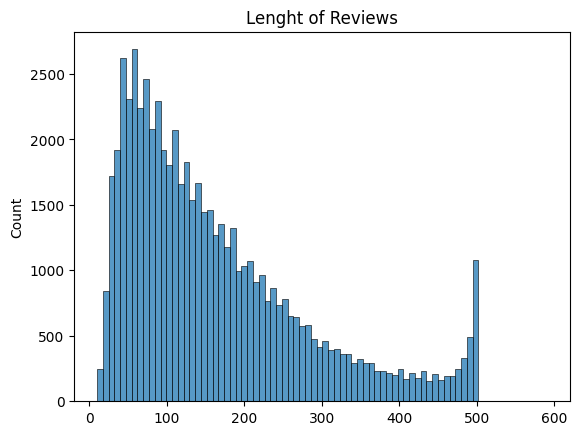

In [16]:
sns.histplot(data['length'][data.length<600])
plt.title('Lenght of Reviews')
plt.xlabel('')
plt.show()

On average reviews with a 5 star rating have the least characters. Reviews with 1,2 or 3 stars, on average have the most charachters.


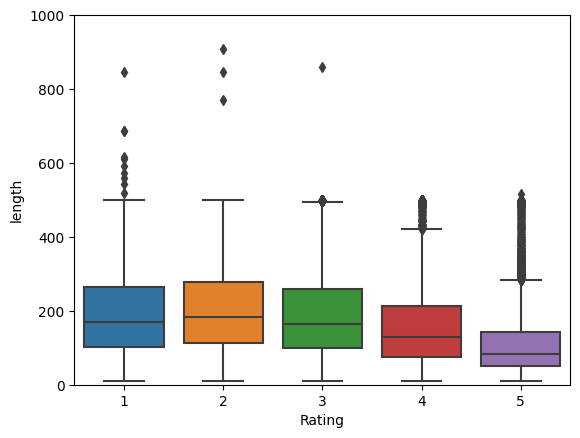

In [17]:
# boxplot of length of reviews based on rating
sns.boxplot(x='Rating', y='length', data=data)
plt.ylim(0, 1000)
plt.show()

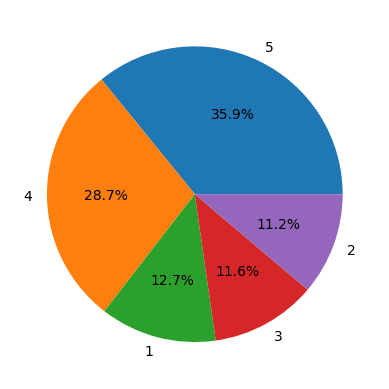

In [18]:
# Distribution of ratings
plt.pie(data['Rating'].value_counts(), labels=data['Rating'].unique(), autopct='%1.1f%%')
plt.show()

In [19]:
# Top used 100 Words before Text Cleaning
FreqOfWords = data['Review'].str.split(expand=True).stack().value_counts()
FreqOfWords_top100 = FreqOfWords[:100]

fig = px.treemap(FreqOfWords_top100, path=[FreqOfWords_top100.index], values=0)
fig.update_layout(title_text='Top used 100 Words before Text Cleaning',
                  title_x=0.5, title_font=dict(size=18)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [20]:
# drop 'Reply', 'Time_submitted' and 'Total_thumbsup'  columns
data.drop(['Reply','Time_submitted', 'Total_thumbsup', 'length'], axis=1, inplace=True)
data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


### Data Preprocessing 

> 1. Remove punctuation

In [21]:
data['Review'] = data['Review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [22]:
data.head()

,Review,Rating
0,Great music service the audio is high quality ...,5
1,Please ignore previous negative rating This ap...,5
2,This popup Get the best Spotify experience on ...,4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didnt p...,1


> 2. Convert text to lowercase

In [23]:
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [24]:
data.head()

,Review,Rating
0,great music service the audio is high quality ...,5
1,please ignore previous negative rating this ap...,5
2,this popup get the best spotify experience on ...,4
3,really buggy and terrible to use as of recently,1
4,dear spotify why do i get songs that i didnt p...,1


> 3. Remove stop words

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(word for word in word.split() if word not in stopwords.words('english')))

In [27]:
data.head()

,Review,Rating
0,great music service audio high quality app eas...,5
1,please ignore previous negative rating app sup...,5
2,popup get best spotify experience android 12 a...,4
3,really buggy terrible use recently,1
4,dear spotify get songs didnt put playlist shuf...,1


> 4. Lemmatization

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
wnl = WordNetLemmatizer()
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(wnl.lemmatize(word) for word in word.split()))

In [30]:
data.head()

,Review,Rating
0,great music service audio high quality app eas...,5
1,please ignore previous negative rating app sup...,5
2,popup get best spotify experience android 12 a...,4
3,really buggy terrible use recently,1
4,dear spotify get song didnt put playlist shuff...,1


#### Convert Rating column to positive, neutral and negative

In [31]:
# Create a copy of the dataset for Flair comparisons
data2 = data.copy()

# Converting App Rating to Sentiments - 1,2 = Negative , 3 = Neutral, 4,5 = Positive (for Vader and TextBlob)
data['Rating'] = data['Rating'].apply(lambda x : 'negative' if x in range(1,3) else ('positive' if x in range(4,6) else 'neutral'))
data.head()

,Review,Rating
0,great music service audio high quality app eas...,positive
1,please ignore previous negative rating app sup...,positive
2,popup get best spotify experience android 12 a...,positive
3,really buggy terrible use recently,negative
4,dear spotify get song didnt put playlist shuff...,negative


In [32]:
# using dataset copy convert app rating to Sentiments : Negative <3.5 , Positive >=3.5 ( For Flair)
def rating_to_sentiment(rating):
    if rating >= 3.5:
        return 'positive'
    else:
        return 'negative'

# Apply the mapping function to the 'rating' column
data2['Rating'] = data2['Rating'].apply(lambda x: rating_to_sentiment(x))

data2.head()

,Review,Rating
0,great music service audio high quality app eas...,positive
1,please ignore previous negative rating app sup...,positive
2,popup get best spotify experience android 12 a...,positive
3,really buggy terrible use recently,negative
4,dear spotify get song didnt put playlist shuff...,negative


### Sentiment Analysis using Vader

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [34]:
# create instance
analyzer = SentimentIntensityAnalyzer()

In [35]:
# Define a function to get the sentiment of a sentence using Vader
def get_vader_sentiment(sent):
    return analyzer.polarity_scores(sent)['compound']

In [36]:
# apply to review column
start = time()
data['result_vader']= data['Review'].apply(get_vader_sentiment)
run_time_vader = time() - start

#categorise sentiment values into positive, negative or neutral
# Positive > 0.05
# Negative < -0.05
# Neutral -0.05< x < 0.05 i.e close to zero
prediction =[]
for i in range(len(data['result_vader'])):
    if data['result_vader'][i]>=0.05:
        prediction.append('positive')
    elif data['result_vader'][i]<=-0.05:
        prediction.append('negative')
    else:
        prediction.append('neutral')  

data['result_vader']= prediction

In [37]:
data.head()

,Review,Rating,result_vader
0,great music service audio high quality app eas...,positive,positive
1,please ignore previous negative rating app sup...,positive,positive
2,popup get best spotify experience android 12 a...,positive,positive
3,really buggy terrible use recently,negative,negative
4,dear spotify get song didnt put playlist shuff...,negative,positive


### Sentiment Analysis using TextBlob

In [38]:
# Define a function to get the sentiment of a sentence using Textblob
def get_textblob_sentiment(sent):
    return TextBlob(sent).sentiment.polarity

In [39]:
# apply to review column
start = time()
data['result_textblob']= data['Review'].apply(get_textblob_sentiment)
run_time_textblob = time() - start


#categorise sentiment values into positive, negative or neutral
prediction2 =[]
for i in range(len(data['result_textblob'])):
    if data['result_textblob'][i]>=0.05:
        prediction2.append('positive')
    elif data['result_textblob'][i]<=-0.05:
        prediction2.append('negative')
    else:
        prediction2.append('neutral')  

data['result_textblob']= prediction2

In [40]:
data.head()

,Review,Rating,result_vader,result_textblob
0,great music service audio high quality app eas...,positive,positive,positive
1,please ignore previous negative rating app sup...,positive,positive,positive
2,popup get best spotify experience android 12 a...,positive,positive,positive
3,really buggy terrible use recently,negative,negative,negative
4,dear spotify get song didnt put playlist shuff...,negative,positive,neutral


### Sentiment Analysis using Flair

In [41]:
# create instance
classifier = TextClassifier.load('en-sentiment')

2023-05-04 02:44:49,565 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmprimidlv7


100%|██████████| 253M/253M [00:25<00:00, 10.3MB/s]

2023-05-04 02:45:16,082 copying /tmp/tmprimidlv7 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-05-04 02:45:16,689 removing temp file /tmp/tmprimidlv7


In [42]:
# Define a function to get the sentiment of a sentence using Flair
def get_flair_sentiment(sent):
  sentence = Sentence(sent)
  classifier.predict(sentence)
  return sentence.labels[0].value

In [43]:
# apply to review column
start = time()
data2['result_flair']= data2['Review'].apply(get_flair_sentiment)
run_time_flair = time() - start

In [44]:
data2.head()

,Review,Rating,result_flair
0,great music service audio high quality app eas...,positive,POSITIVE
1,please ignore previous negative rating app sup...,positive,NEGATIVE
2,popup get best spotify experience android 12 a...,positive,NEGATIVE
3,really buggy terrible use recently,negative,NEGATIVE
4,dear spotify get song didnt put playlist shuff...,negative,NEGATIVE


In [45]:
# change result_flair column to lowercase
data2.loc[:,'result_flair'] = data2.loc[:,'result_flair'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data2.head()

,Review,Rating,result_flair
0,great music service audio high quality app eas...,positive,positive
1,please ignore previous negative rating app sup...,positive,negative
2,popup get best spotify experience android 12 a...,positive,negative
3,really buggy terrible use recently,negative,negative
4,dear spotify get song didnt put playlist shuff...,negative,negative


### Comparing Results

> Prediction distributions

- Vader and Textblob give sentiment scores ranging from -1 to 1. Values less than zero mean the text is negative, values greater than zero mean the text is positive, values close to 0 mean the text is neutral.

- Flair gives a label (positive / negative) together with its confidence score. The confidence score ranges from 0 to 1 with 0 being not confident at all and 1 being highly confident.

- In terms of distribution of predictions, vader predicted more positive reviews with 68% closely followed by textblob with 62.7% and 38% with Flair, which is considerably lower. Textblob predicted more neutral reviews compared to vader.

Text(0.5, 1.0, 'Flair')

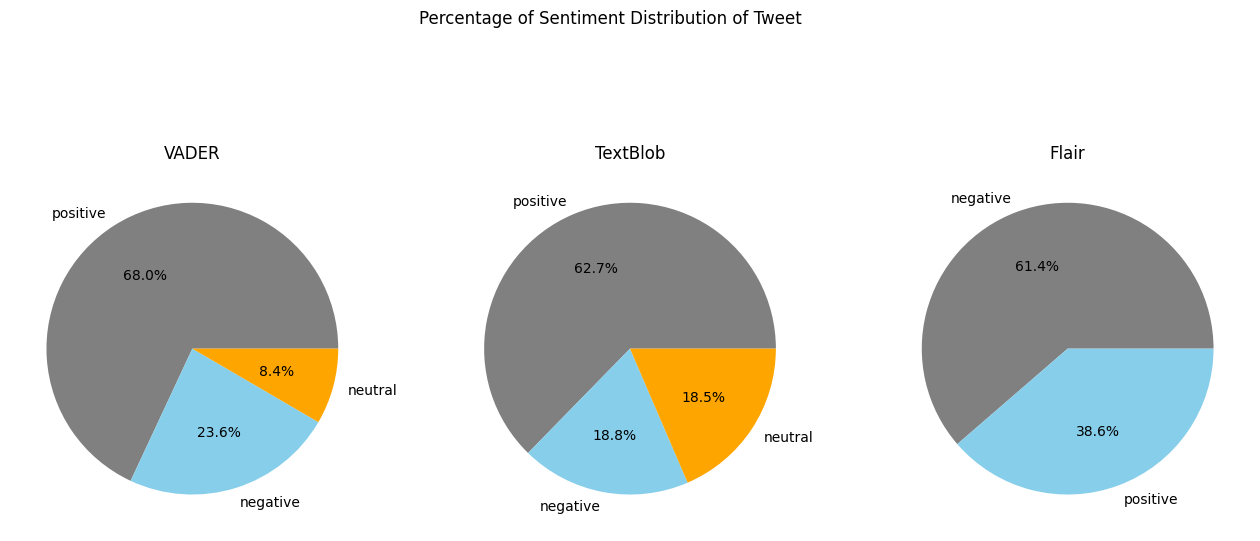

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
fig.suptitle('Percentage of Sentiment Distribution of Tweet')

# VADER
percentage_vader = pd.DataFrame((data['result_vader'].value_counts()/len(data))*100)
percentage_vader.reset_index(inplace=True)
percentage_vader.columns = ['Sentiment','Percentage']
axes[0].pie(percentage_vader['Percentage'],
        labels=percentage_vader['Sentiment'],
        autopct='%1.1f%%',
        colors=['grey','skyblue','orange'])
axes[0].set_title("VADER")
fig.show()

# TextBlob
percentage_textblob = pd.DataFrame((data['result_textblob'].value_counts()/len(data))*100)
percentage_textblob.reset_index(inplace=True)
percentage_textblob.columns = ['Sentiment','Percentage']
axes[1].pie(percentage_textblob['Percentage'],
        labels=percentage_textblob['Sentiment'],
        autopct='%1.1f%%',
        colors=['grey','skyblue','orange'])
axes[1].set_title("TextBlob")

# Flair
percentage_flair = pd.DataFrame((data2['result_flair'].value_counts()/len(data2))*100)
percentage_flair.reset_index(inplace=True)
percentage_flair.columns = ['Sentiment','Percentage']
axes[2].pie(percentage_flair['Percentage'],
        labels=percentage_flair['Sentiment'],
        autopct='%1.1f%%',
        colors=['grey','skyblue'])
axes[2].set_title("Flair")

> Accuracy

- The best performing is Flair with a 81% accuracy followed by Vader with 62% and lastly Textblob with 58% not far behind.

In [47]:
from sklearn.metrics import classification_report,auc,roc_auc_score,accuracy_score
target_names = ['negative', 'neutral', 'positive']
print(f" Accuracy of Vader: {accuracy_score(data['Rating'],data['result_vader'])}\n \
Accuracy of Textbob: {accuracy_score(data['Rating'],data['result_textblob'])}\n \
Accuracy of Flair: {accuracy_score(data2['Rating'],data2['result_flair'])}")

 Accuracy of Vader: 0.6216352242101504
 Accuracy of Textbob: 0.5859824008832029
 Accuracy of Flair: 0.8134071500470825


> Speed

- Vader and Textblob take roughly the same time to run, however flair takes the longest. Almost 30 times as long to run.

In [48]:
print(f" Run time of Vader: {run_time_vader}\n \
Run time of Textblob: {run_time_textblob}\n \
Run time of Flair: {run_time_flair}")

 Run time of Vader: 13.254247665405273
 Run time of Textblob: 13.151723623275757
 Run time of Flair: 440.9935474395752
